<a href="https://colab.research.google.com/github/eunjipark123/olist_sellerside_analysis/blob/main/Olist_seller_sales_analysis_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. 준비
## 1. 분석에 필요한 라이브러리와 파일 불러오기

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# 마케팅 퍼널 분석에 필요한 자료 리드

# 단계 별 데이터
mql = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_marketing_qualified_leads_dataset.csv") # mql 단계
cd = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_closed_deals_dataset.csv") # cd 단계
order_items = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_order_items_dataset.csv") # 주문-판매 단계 (아이템)
orders = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_orders_dataset.csv") # 주문-판매 단계 (주문 시각)


# 현재 불필요하다고 판단되는 데이터
#sellers = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_sellers_dataset.csv")
#customers = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_customers_dataset.csv")
#location = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_geolocation_dataset.csv")
# order_payments = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_order_payments_dataset.csv")
# categories = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/product_category_name_translation.csv")
# products = pd.read_csv("/content/drive/MyDrive/olist/01_dataset/olist_products_dataset.csv") # 상품 정보 

## 2. 테이블 확인 
- EDA를 통해 테이블 정보를 확인해본다. 

### 1) mql 테이블

In [ ]:
# 총 4개의 컬럼과 8천 개의 자료로 구성됨 
# origin에 60개의 결측치 있음
# first_contact_date는 데이터 타입이 object로 데이터 타입 변경 필요

mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mql_id              8000 non-null   object
 1   first_contact_date  8000 non-null   object
 2   landing_page_id     8000 non-null   object
 3   origin              7940 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB


In [ ]:
# 데이터 타입 변경 (first_contact_date)
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])

In [ ]:
mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mql_id              8000 non-null   object        
 1   first_contact_date  8000 non-null   datetime64[ns]
 2   landing_page_id     8000 non-null   object        
 3   origin              7940 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 250.1+ KB


In [ ]:
# first_contact_date 추이 
# 2018년 1월 이후 first_contact까지 간 leads 수가 급증하는 것을 알 수 있다. 
fc_date_trends = pd.DataFrame(mql.groupby([mql.first_contact_date.dt.year, mql.first_contact_date.dt.month])['mql_id'].count())
fc_date_trends.reset_index(level = 0, inplace = True)
fc_date_trends = fc_date_trends.rename(columns = {'first_contact_date' : 'fc_year', 'mql_id' : 'leads_cnt'})
fc_date_trends.reset_index(inplace = True)
fc_date_trends = fc_date_trends.rename(columns = {'first_contact_date' : 'fc_month'})
fc_date_trends = fc_date_trends[['fc_year', 'fc_month', 'leads_cnt']]
fc_date_trends

,fc_year,fc_month,leads_cnt
0,2017,6,4
1,2017,7,239
2,2017,8,386
3,2017,9,312
4,2017,10,416
5,2017,11,445
6,2017,12,200
7,2018,1,1141
8,2018,2,1028
9,2018,3,1174


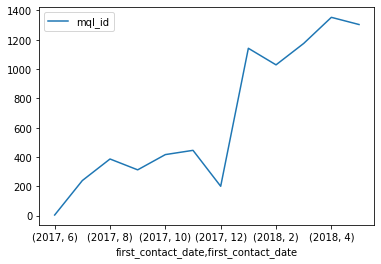

In [ ]:
pd.DataFrame(mql.groupby([mql.first_contact_date.dt.year, mql.first_contact_date.dt.month])['mql_id'].count()).plot()

In [ ]:
# landing_page의 고유한 값이 약 495개 있음 
# 이중 top5는 최소 394명의 유저가 방문한 랜딩 페이지 유형을 의미함
pd.Series(mql['landing_page_id'].value_counts()).head(5)

b76ef37428e6799c421989521c0e5077    912
22c29808c4f815213303f8933030604c    883
58326e62183c14b0c03085c33b9fdc44    495
88740e65d5d6b056e0cda098e1ea6313    445
ce1a65abd0973638f1c887a6efcfa82d    394
Name: landing_page_id, dtype: int64

In [ ]:
# mql 채널 정보는 다음과 같음 
# paid_search : 유료 검색 광고
# social : sns
# direct_traffic : 직접 접속 
# display : 온라인 배너 광고 
# other_publicities : 홍보

# unknown은 채널 경로를 알 수 없으나, 개체 수가 많은 만큼 무시할 수 없음 --> 12/16 결론 : unknown과 other, null값을 unknown으로 통합  --> 12/20 : other_publicities도 통합
mql['origin'].value_counts()

organic_search       2296
paid_search          1586
social               1350
unknown              1099
direct_traffic        499
email                 493
referral              284
other                 150
display               118
other_publicities      65
Name: origin, dtype: int64

In [ ]:
mql.loc[mql['origin'] == 'other','origin'] = 'unknown'
mql.loc[mql['origin'] == 'other_publicities','origin'] = 'unknown' # 12/20 추가
mql.loc[mql['origin'].isna(),'origin'] = 'unknown'

In [ ]:
# origin에서 other, other_publicties, null값이 모두 unknown으로 편입된 것을 볼 수 있다. 
mql['origin'].value_counts()

organic_search    2296
paid_search       1586
unknown           1374
social            1350
direct_traffic     499
email              493
referral           284
display            118
Name: origin, dtype: int64

In [ ]:
mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   mql_id              8000 non-null   object        
 1   first_contact_date  8000 non-null   datetime64[ns]
 2   landing_page_id     8000 non-null   object        
 3   origin              8000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 250.1+ KB


### 2) cd(closed_deals) 테이블

In [ ]:
# cd 테이블은 mql 테이블의 lead 중 olist의 seller로 전환된 (셀러)고객을 의미함
# 842명이 셀러로 전환되었으며, 계약을 성사시킨 sdr, sr 직원의 정보와 체결 날짜를 알 수 있다. 
# 계약 당시 셀러가 기입한 비즈니스 정보에 대해서 알 수 있음
# 이 중 has_company, has_gtin, avergage_stock, declared_product_catalog_size는 null값이 많아 분석으로 상요 불가능
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         842 non-null    object 
 1   seller_id                      842 non-null    object 
 2   sdr_id                         842 non-null    object 
 3   sr_id                          842 non-null    object 
 4   won_date                       842 non-null    object 
 5   business_segment               841 non-null    object 
 6   lead_type                      836 non-null    object 
 7   lead_behaviour_profile         665 non-null    object 
 8   has_company                    63 non-null     object 
 9   has_gtin                       64 non-null     object 
 10  average_stock                  66 non-null     object 
 11  business_type                  832 non-null    object 
 12  declared_product_catalog_size  69 non-null     flo

In [ ]:
# won_date의 데이터타입을 '날짜'로 변경
cd['won_date'] = pd.to_datetime(cd['won_date'])

In [ ]:
# business_type에 어떤 값들이 있는지 확인
# nan값은 other로 편입시키기
cd['business_type'].unique()

array(['reseller', 'manufacturer', 'other', nan], dtype=object)

In [ ]:
cd.loc[cd['business_type'] == 'nan', 'business_type'] = 'other'
cd.loc[cd['business_type'].isna(), 'business_type'] = 'other'

In [ ]:
# nan, null값이 other로 변경되었음
cd['business_type'].unique()

array(['reseller', 'manufacturer', 'other'], dtype=object)

### 3) orders, order_items

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
# 주로 사용할 opt를 date 형식으로 변경
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

## 3. 필요한 테이블 준비하기

### 1) mf 테이블 : mql & olist (by = mql_id)
- 첫 연락을 받은 Olist 리드(잠재 셀러) 중 계약 체결을 통해 셀러로 전환된 셀러 정보를 확인할 수 있음
- 해석1. mql_id는 있지만, seller_id는 없는 경우 셀러로 전환되지 않은 것 
- 해석2. mql_id도 있고 seller_id도 있다면 셀러로 전환된 것


In [ ]:
# mql 테이블과 closed_deals 테이블이 1:1 관계이므로 중복 이슈 없음
mf = mql.merge(cd, how = 'left', on = 'mql_id')
mf.head(2)

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         8000 non-null   object        
 4   seller_id                      842 non-null    object        
 5   sdr_id                         842 non-null    object        
 6   sr_id                          842 non-null    object        
 7   won_date                       842 non-null    datetime64[ns]
 8   business_segment               841 non-null    object        
 9   lead_type                      836 non-null    object        
 10  lead_behaviour_profile         665 non-null    object        
 11  has_company      

### 2) seller_first_order 테이블 : orders, order_items 테이블 (by = order_id)
- 주문 이력이 있는 셀러 중 첫 주문을 받은 날짜 정보를 확인할 수 있다. 
- order_with_items 테이블 : order_items 테이블과 합치기 (seller_ 별 order 정보를 확인하기 위해)
- seller_first_order 테이블 : orders 테이블에서 첫 주문 데이터만 남겨놓기 (first_order 계약 체결 후 처음 주문까지의 퍼널이 필요하므로, 중복 데이터 방지)


In [ ]:
# order_with_items 테이블 만들기 (order_id를 기준으로 이너 조인한다.)
order_with_items = orders.merge(order_items, how = 'inner', on='order_id')
order_with_items.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76


In [ ]:
# seller_id 별로 최초의 주문만 남겨두기 (opt가 가장 빠른 시점인 주문건만 남겨둔다)
seller_first_order = pd.DataFrame(order_with_items.groupby('seller_id')['order_purchase_timestamp'].min())
seller_first_order.head(3)

,order_purchase_timestamp
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-26 22:17:05
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:06:04
001e6ad469a905060d959994f1b41e4f,2018-08-07 22:50:37


In [ ]:
seller_first_order.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3095 entries, 0015a82c2db000af6aaaf3ae2ecb0532 to ffff564a4f9085cd26170f4732393726
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  3095 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 48.4+ KB


### 3) mf_orders 테이블 : mf테이블, seller_first_order 테이블 (최종)
- mql 리드 중 셀러로 전환된 셀러 수, 셀러 중 판매까지 완료된 셀러 수를 알 수 있음 (전환율 측정)
- first_contact_date, won_date, order_purchase_timestamp까지의 리드타임을 파악할 수 있음

In [ ]:
mf_orders = mf.merge(seller_first_order, how = 'left', on = 'seller_id')
mf_orders.head(5)

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,order_purchase_timestamp
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-06-20 21:40:18


In [ ]:
mf_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         8000 non-null   object        
 1   first_contact_date             8000 non-null   datetime64[ns]
 2   landing_page_id                8000 non-null   object        
 3   origin                         8000 non-null   object        
 4   seller_id                      842 non-null    object        
 5   sdr_id                         842 non-null    object        
 6   sr_id                          842 non-null    object        
 7   won_date                       842 non-null    datetime64[ns]
 8   business_segment               841 non-null    object        
 9   lead_type                      836 non-null    object        
 10  lead_behaviour_profile         665 non-null    object        
 11  has_company      

# II. 분석

## 1. 전체 전환율 측정 
- MQL -> cd_conversion rate : closed_deal 단계의 셀러 수 / mql 단계의 리드 수 * 100(%), 셀러 수 측정 기준(seller_id), 리드 수 측정 기준(mql_id)
- SQL -> selling_conversion_rate : 주문 내역이 있는 셀러 수 / closed_deals 단계의 셀러 수 * 100(%), 주문 내역 있는 셀러 수 측정 기준(주문 내역 조건을 만족하는 셀러 seller_id)

In [ ]:
# 각 단계 별 사람 수
mql_general = mf_orders['mql_id'].count() # 리드 수
cd_general = mf_orders['seller_id'].count() # 셀러로 전환된 리드 수
order_general = mf_orders.loc[mf_orders['order_purchase_timestamp'].notna(), 'seller_id'].count() # 판매 기록이 있는 셀러 수

print(mql_general, cd_general, order_general)

8000 842 380


In [ ]:
# 전환율 측정
general_contract_conversion_rate = cd_general / mql_general * 100
general_order_conversion_rate = order_general / cd_general * 100
print(general_contract_conversion_rate, general_order_conversion_rate)

10.525 45.13064133016627


In [ ]:
# 전체 전환율을 표로 나타내면 다음과 같다
conversion_total = {'leads': mql_general, 'contracted_sellers': cd_general, 'ordered_sellers' : order_general, 'contract_cvr' : general_contract_conversion_rate, 'order_cvr' : general_order_conversion_rate}
pd.DataFrame(conversion_total, index = [0])

,leads,contracted_sellers,ordered_sellers,contract_cvr,order_cvr
0,8000,842,380,10.525,45.130641


- 전환율을 퍼널로 시각화하기

In [ ]:
# 퍼널 단계를 리스트로 표현
general_funnels = [mql_general, cd_general, order_general]

In [ ]:
# plotly 라이브러리로 퍼널 표현하기
data = dict(
    number = general_funnels,
    stage = ['mql','cd','order'])

fig = px.funnel(data, x='number', y='stage')
fig.show()

## 2. 코호트 별 전환율 측정
- 세부 코호트 별로 전환율을 측정하고 비교해본다. 

### 1) 유입 경로(origin) 별 전환율


- 전체 전환율 (기간 무관)

In [ ]:
# 유입 경로 별 판매 셀러 수를 측정하기 위해 판매 이력이 있는 셀러들만 출력
ordered_sellers_list = pd.DataFrame(mf_orders.loc[mf_orders['order_purchase_timestamp'].notna(), 'seller_id'])

# mf_orders 테이블과 연동하여 판매 이력이 있는 셀러들로만 테이블 구성
mf_orders_ordered_sellers = mf_orders.merge(ordered_sellers_list, how = 'inner', on = 'seller_id')

In [ ]:
# 유입 경로 별 리드, 셀러, 판매 셀러 수 측정

# 리드 수
lead_per_origin = pd.DataFrame(mf.groupby('origin')['mql_id'].count().sort_values(ascending = False)) 
lead_per_origin.rename(columns = {'mql_id' : 'leads'}, inplace = True)

# 판매자 전환 수
seller_per_origin = pd.DataFrame(mf.groupby('origin')['seller_id'].count().sort_values(ascending = False)) 
seller_per_origin.rename(columns = {'seller_id' : 'sellers_contracted'}, inplace = True)

# 주문 전환 수
seller_ordered_per_origin = pd.DataFrame(mf_orders_ordered_sellers.groupby('origin')['seller_id'].count().sort_values(ascending = False)) 
seller_ordered_per_origin.rename(columns = {'seller_id' : 'sellers_ordered'}, inplace = True)

In [ ]:
# 유입 경로 별 셀러 전환 수, 전환율 측정

a = lead_per_origin.merge(seller_per_origin, how = 'left', on = 'origin')
conversion_per_origin = a.merge(seller_ordered_per_origin, how = 'left', on = 'origin')
conversion_per_origin['sellers_ordered'].fillna(0, inplace = True)
conversion_per_origin['seller_conversion_rate(%)'] = conversion_per_origin['sellers_contracted'] / conversion_per_origin['leads'] * 100
conversion_per_origin['order_conversion_rate(%)'] = conversion_per_origin['sellers_ordered'] / conversion_per_origin['sellers_contracted'] * 100
conversion_per_origin

,leads,sellers_contracted,sellers_ordered,seller_conversion_rate(%),order_conversion_rate(%)
origin,,,,,
organic_search,2296,271,113,11.803136,41.697417
paid_search,1586,195,101,12.295082,51.794872
unknown,1374,200,87,14.556041,43.500000
social,1350,75,31,5.555556,41.333333
direct_traffic,499,56,31,11.222445,55.357143
email,493,15,6,3.042596,40.000000
referral,284,24,9,8.450704,37.500000
display,118,6,2,5.084746,33.333333


In [ ]:
# 시각화

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = conversion_per_origin.index
column0 = conversion_per_origin['seller_conversion_rate(%)']
column1 = conversion_per_origin['order_conversion_rate(%)']
title0 = 'seller_conversion_rate(%)'
title1 = 'order_conversion_rate(%)'

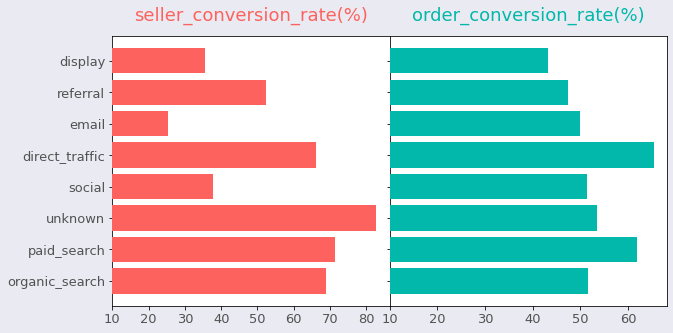

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
# ax.set_xlim(right=15)  # adjust xlim to fit labels
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# axes[0].invert_xaxis() 
# plt.gca().invert_yaxis()

axes[0].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
axes[1].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


plt.show()

### 2) landing_page_id 별 전환율 

#### 1️⃣ 전체 기간

##### 시도1 : 모든 landing_page_id 별 전환율 측정

In [ ]:
# 판매 이력이 있는 셀러 테이블 : mf_orders_ordered_sellers

In [ ]:
# landing_page_id 별 리드, 셀러, 판매 셀러 수 측정

# 리드 수
lead_per_landing = pd.DataFrame(mf.groupby('landing_page_id')['mql_id'].count().sort_values(ascending = False)) 
lead_per_landing.rename(columns = {'mql_id' : 'leads'}, inplace = True)

# 판매자 전환 수
seller_per_landing = pd.DataFrame(mf.groupby('landing_page_id')['seller_id'].count().sort_values(ascending = False)) 
seller_per_landing.rename(columns = {'seller_id' : 'sellers_contracted'}, inplace = True)

# 주문 전환 수
seller_ordered_per_landing = pd.DataFrame(mf_orders_ordered_sellers.groupby('landing_page_id')['seller_id'].count().sort_values(ascending = False)) 
seller_ordered_per_landing.rename(columns = {'seller_id' : 'sellers_ordered'}, inplace = True)

In [ ]:
# 유입 경로 별 셀러 전환 수, 전환율 측정

c = lead_per_landing.merge(seller_per_landing, how = 'left', on = 'landing_page_id')
conversion_per_landing = c.merge(seller_ordered_per_landing, how = 'left', on = 'landing_page_id')
conversion_per_landing['sellers_ordered'].fillna(0, inplace = True)
conversion_per_landing['seller_conversion_rate(%)'] = conversion_per_landing['sellers_contracted'] / conversion_per_landing['leads'] * 100
conversion_per_landing['order_conversion_rate(%)'] = conversion_per_landing['sellers_ordered'] / conversion_per_landing['sellers_contracted'] * 100
conversion_per_landing

,leads,sellers_contracted,sellers_ordered,seller_conversion_rate(%),order_conversion_rate(%)
landing_page_id,,,,,
b76ef37428e6799c421989521c0e5077,912,171,81.0,18.750000,47.368421
22c29808c4f815213303f8933030604c,883,174,82.0,19.705549,47.126437
58326e62183c14b0c03085c33b9fdc44,495,27,11.0,5.454545,40.740741
88740e65d5d6b056e0cda098e1ea6313,445,31,14.0,6.966292,45.161290
ce1a65abd0973638f1c887a6efcfa82d,394,59,29.0,14.974619,49.152542
...,...,...,...,...,...
2204d1cf0ec6a0cf20f7342e99d88ec8,1,0,0.0,0.000000,NaN
8345a83d419160e69c0501b494dadfa6,1,0,0.0,0.000000,NaN
83355a82a9cee26f3ba2b186ddb0bbbe,1,1,0.0,100.000000,0.000000


In [ ]:
# 시각화

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = conversion_per_landing.index
column0 = conversion_per_landing['seller_conversion_rate(%)']
column1 = conversion_per_landing['order_conversion_rate(%)']
title0 = 'seller_conversion_rate(%)'
title1 = 'order_conversion_rate(%)'

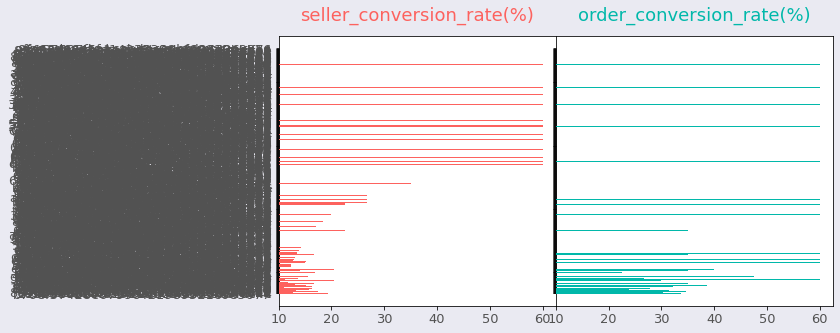

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
# ax.set_xlim(right=15)  # adjust xlim to fit labels
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# axes[0].invert_xaxis() 
# plt.gca().invert_yaxis()

axes[0].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
axes[1].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


# 실행 시 오래 걸림 .. 
plt.show()

##### 시도2. 50명 이상 본 랜딩페이지로 한정
- 랜딩 페이지 수가 너무 많아 비교가 어려우므로, 50명 이상이 본 페이지로만 한정해서 보기

In [ ]:
# 페이지 별 집계
mf_landing_cut = pd.DataFrame(mf.groupby('landing_page_id')['mql_id'].count())
mf_landing_cut.rename(columns = {'mql_id':'leads'}, inplace = True)

# mf 테이블과 결합
mf_landing = mf.merge(mf_landing_cut, how = 'inner', on = 'landing_page_id')
mf_landing_final = mf_landing.loc[mf_landing['leads'] >= 50]

# mf_orders_ordered_sellers 테이블과 결합
mf_orders_landing = mf_orders_ordered_sellers.merge(mf_landing_cut, how = 'inner', on = 'landing_page_id')
mf_orders_landing_final = mf_orders_landing.loc[mf_landing['leads'] >= 50]



# landing_page_id 별 리드, 셀러, 판매 셀러 수 측정
# 리드 수
lead_per_landing_50 = pd.DataFrame(mf_landing_final.groupby('landing_page_id')['mql_id'].count().sort_values(ascending = False)) 
lead_per_landing_50.rename(columns = {'mql_id' : 'leads'}, inplace = True)

# 판매자 전환 수
seller_per_landing_50 = pd.DataFrame(mf_landing_final.groupby('landing_page_id')['seller_id'].count().sort_values(ascending = False)) 
seller_per_landing_50.rename(columns = {'seller_id' : 'sellers_contracted'}, inplace = True)

# 주문 전환 수
seller_ordered_per_landing_50 = pd.DataFrame(mf_orders_landing_final.groupby('landing_page_id')['seller_id'].count().sort_values(ascending = False)) 
seller_ordered_per_landing_50.rename(columns = {'seller_id' : 'sellers_ordered'}, inplace = True)

In [ ]:
d = lead_per_landing_50.merge(seller_per_landing_50, how = 'left', on = 'landing_page_id')
conversion_per_landing_50 = d.merge(seller_ordered_per_landing_50, how = 'left', on = 'landing_page_id')
conversion_per_landing_50['sellers_ordered'].fillna(0, inplace = True)
conversion_per_landing_50['seller_conversion_rate(%)'] = conversion_per_landing_50['sellers_contracted'] / conversion_per_landing_50['leads'] * 100
conversion_per_landing_50['order_conversion_rate(%)'] = conversion_per_landing_50['sellers_ordered'] / conversion_per_landing_50['sellers_contracted'] * 100
conversion_per_landing_50.head(2)

,leads,sellers_contracted,sellers_ordered,seller_conversion_rate(%),order_conversion_rate(%)
landing_page_id,,,,,
b76ef37428e6799c421989521c0e5077,912,171,81.0,18.750000,47.368421
22c29808c4f815213303f8933030604c,883,174,82.0,19.705549,47.126437


In [ ]:
# 시각화

In [ ]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = conversion_per_landing_50.index
column0 = conversion_per_landing_50['seller_conversion_rate(%)']
column1 = conversion_per_landing_50['order_conversion_rate(%)']
title0 = 'seller_conversion_rate(%)'
title1 = 'order_conversion_rate(%)'

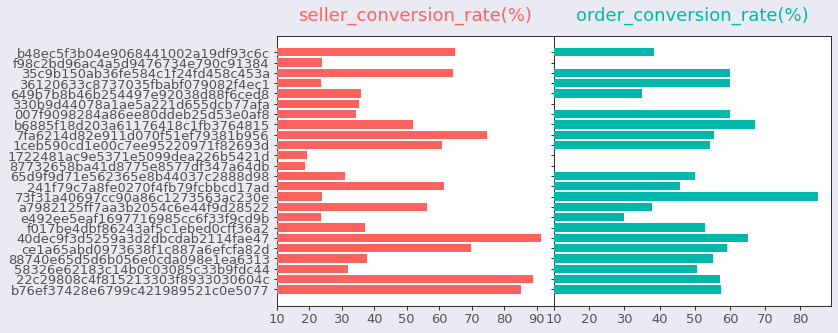

In [ ]:
fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
# ax.set_xlim(right=15)  # adjust xlim to fit labels
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# axes[0].invert_xaxis() 
# plt.gca().invert_yaxis()

axes[0].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
axes[1].set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


# 실행 시 오래 걸림 .. 
plt.show()


In [ ]:
seller_cvr = conversion_per_landing_50.sort_values(by = 'seller_conversion_rate(%)', ascending = False)
order_cvr = conversion_per_landing_50.sort_values(by = 'order_conversion_rate(%)', ascending = False)

In [ ]:
# 셀러 전환율이 높은 상위 5개의 랜딩 페이지
seller_cvr.head(5)

,leads,sellers_contracted,sellers_ordered,seller_conversion_rate(%),order_conversion_rate(%)
landing_page_id,,,,,
40dec9f3d5259a3d2dbcdab2114fae47,330,67,37.0,20.303030,55.223881
22c29808c4f815213303f8933030604c,883,174,82.0,19.705549,47.126437
b76ef37428e6799c421989521c0e5077,912,171,81.0,18.750000,47.368421
7fa6214d82e911d070f51ef79381b956,68,11,5.0,16.176471,45.454545
ce1a65abd0973638f1c887a6efcfa82d,394,59,29.0,14.974619,49.152542


In [ ]:
# 주문 전환율이 높은 상위 5개 랜딩 페이지
order_cvr.head(5)

,leads,sellers_contracted,sellers_ordered,seller_conversion_rate(%),order_conversion_rate(%)
landing_page_id,,,,,
73f31a40697cc90a86c1273563ac230e,115,4,3.0,3.478261,75.000000
b6885f18d203a61176418c1fb3764815,67,7,4.0,10.447761,57.142857
40dec9f3d5259a3d2dbcdab2114fae47,330,67,37.0,20.303030,55.223881
35c9b150ab36fe584c1f24fd458c453a,59,8,4.0,13.559322,50.000000
36120633c8737035fbabf079082f4ec1,59,2,1.0,3.389831,50.000000


In [ ]:
# 랜딩 페이지에 접근한 리드 수와 전환율을 같이 본다면? (b2b 데이터 참고)

#### 2️⃣ first_contact_date에 따른 landing_page_id 별 전환율 추이

In [ ]:
# first_contact_date를 연-월로 표기 -> first_contact_month 컬럼 추가
mf_landing_final['first_contact_month'] = pd.to_datetime(mf_landing_final['first_contact_date']).dt.to_period('M')
mf_orders_landing_final['first_contact_month'] = pd.to_datetime(mf_orders_landing_final['first_contact_date']).dt.to_period('M')

<ipython-input-66-6d1ee3750901>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
mf_landing_final.head(5)

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,leads,first_contact_month
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445,2018-02
1,7281942387a1a0c3f72a50a8b0bb0920,2017-12-25,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445,2017-12
2,8e7af20b649bd58357ffc4aa7cf5e88f,2018-02-08,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445,2018-02
3,936c567e63dabf5ab46ed2440f376fc8,2018-02-20,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445,2018-02
4,aa839cfb74f9e5ae2a89572a0093dd58,2018-01-29,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,445,2018-01


In [ ]:
mf_orders_landing_final.head(5)

,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,order_purchase_timestamp,leads,first_contact_month
0,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-06-20 21:40:18,51,2018-02
1,6548cf02964800e58014e5040bb14e01,2017-11-14,b48ec5f3b04e9068441002a19df93c6c,paid_search,88cd3681e0a2ba85e190f7d817629c4c,b90f87164b5f8c2cfa5c8572834dbe3f,2695de1affa7750089c0455f8ce27021,2018-07-09 18:00:57,car_accessories,online_big,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-08-15 21:09:19,51,2017-11
2,327174d3648a2d047e8940d7d15204ca,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-06-11 14:32:25,71,2018-04
3,ab11f58a6bf7036a656364b0ba68fb74,2018-04-05,1ceb590cd1e00c7ee95220971f82693d,paid_search,9e7c5f4d7770eab65738cca38f9efccf,068066e24f0c643eb1d089c7dd20cd73,de63de0d10a6012430098db33c679b0b,2018-04-10 03:00:00,sports_leisure,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-06-01 12:50:14,71,2018-04
4,e0bcbf50b9afa71ee130b94dfe8bcf2e,2018-05-02,1ceb590cd1e00c7ee95220971f82693d,paid_search,516e7738bd8f735ac19a010ee5450d8d,9d12ef1a7eca3ec58c545c678af7869c,495d4e95a8cf8bbf8b432b612a2aa328,2018-05-08 13:32:34,health_beauty,online_small,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-05-11 18:34:36,71,2018-05


In [ ]:
# first_contact_month, landing_page_id 별 리드, 셀러, 판매 셀러 수 측정
# 리드 수
lead_per_landing_first_50 = pd.DataFrame(mf_landing_final.groupby(['first_contact_month','landing_page_id'])['mql_id'].count().sort_values(ascending = False)) 
lead_per_landing_first_50.rename(columns = {'mql_id' : 'leads'}, inplace = True)

# 판매자 전환 수
seller_per_landing_first_50 = pd.DataFrame(mf_landing_final.groupby(['first_contact_month','landing_page_id'])['seller_id'].count().sort_values(ascending = False)) 
seller_per_landing_first_50.rename(columns = {'seller_id' : 'sellers_contracted'}, inplace = True)

# 주문 전환 수
seller_ordered_per_landing_first_50 = pd.DataFrame(mf_orders_landing_final.groupby(['first_contact_month','landing_page_id'])['seller_id'].count().sort_values(ascending = False)) 
seller_ordered_per_landing_first_50.rename(columns = {'seller_id' : 'sellers_ordered'}, inplace = True)


In [ ]:
lead_per_landing_first_50

,,leads
first_contact_month,landing_page_id,
2018-04,58326e62183c14b0c03085c33b9fdc44,233
2018-05,58326e62183c14b0c03085c33b9fdc44,221
2018-04,22c29808c4f815213303f8933030604c,167
2018-05,22c29808c4f815213303f8933030604c,161
2018-01,b76ef37428e6799c421989521c0e5077,160
...,...,...
2017-12,007f9098284a86ee80ddeb25d53e0af8,1
2017-09,1722481ac9e5371e5099dea226b5421d,1
2017-10,87732658ba41d8775e8577df347a64db,1


In [ ]:
e = lead_per_landing_first_50.merge(seller_per_landing_first_50, how = 'left', on = ['first_contact_month','landing_page_id'])
conversion_per_landing_first_50 = e.merge(seller_ordered_per_landing_first_50, how = 'left', on = ['first_contact_month','landing_page_id'])
conversion_per_landing_first_50['sellers_ordered'].fillna(0, inplace = True)
conversion_per_landing_first_50['seller_conversion_rate(%)'] = conversion_per_landing_first_50['sellers_contracted'] / conversion_per_landing_first_50['leads'] * 100
conversion_per_landing_first_50['order_conversion_rate(%)'] = conversion_per_landing_first_50['sellers_ordered'] / conversion_per_landing_first_50['sellers_contracted'] * 100
conversion_per_landing_first_50.sort_values(by = 'first_contact_month', ascending = True, inplace = True)
conversion_per_landing_first_50

leads  \
first_contact_month landing_page_id                           
2017-07             b6885f18d203a61176418c1fb3764815      4   
                    007f9098284a86ee80ddeb25d53e0af8      3   
                    b76ef37428e6799c421989521c0e5077     21   
                    b48ec5f3b04e9068441002a19df93c6c      2   
                    241f79c7a8fe0270f4fb79fcbbcd17ad      2   
...                                                     ...   
2018-05             35c9b150ab36fe584c1f24fd458c453a     32   
                    e492ee5eaf1697716985cc6f33f9cd9b     40   
                    1ceb590cd1e00c7ee95220971f82693d     40   
                    7fa6214d82e911d070f51ef79381b956     17   
                    36120633c8737035fbabf079082f4ec1     10   

                                                      sellers_contracted  \
first_contact_month landing_page_id                                        
2017-07             b6885f18d203a61176418c1fb3764815                   0   
                    007f9098284a86ee80ddeb25d53e0af8                   0   
                    b76ef37428e6799c421989521c0e5077                   1   
                    b48ec5f3b04e9068441002a19df93c6c                   0   
                    241f79c7a8fe0270f4fb79fcbbcd17ad                   0   
...                                                                  ...   
2018-05             35c9b150ab36fe584c1f24fd458c453a                   4   
                    e492ee5eaf1697716985cc6f33f9cd9b                   1   
                    1ceb590cd1e00c7ee95220971f82693d                   5   
                    7fa6214d82e911d070f51ef79381b956                   3   
                    36120633c8737035fbabf079082f4ec1                   0   

                                                      sellers_ordered  \
first_contact_month landing_page_id                                     
2017-07             b6885f18d203a61176418c1fb3764815              0.0   
                    007f9098284a86ee80ddeb25d53e0af8              0.0   
                    b76ef37428e6799c421989521c0e5077              1.0   
                    b48ec5f3b04e9068441002a19df93c6c              0.0   
                    241f79c7a8fe0270f4fb79fcbbcd17ad              0.0   
...                                                               ...   
2018-05             35c9b150ab36fe584c1f24fd458c453a              1.0   
                    e492ee5eaf1697716985cc6f33f9cd9b              0.0   
                    1ceb590cd1e00c7ee95220971f82693d              1.0   
                    7fa6214d82e911d070f51ef79381b956              1.0   
                    36120633c8737035fbabf079082f4ec1              0.0   

                                                      seller_conversion_rate(%)  \
first_contact_month landing_page_id                                               
2017-07             b6885f18d203a61176418c1fb3764815                   0.000000   
                    007f9098284a86ee80ddeb25d53e0af8                   0.000000   
                    b76ef37428e6799c421989521c0e5077                   4.761905   
                    b48ec5f3b04e9068441002a19df93c6c                   0.000000   
                    241f79c7a8fe0270f4fb79fcbbcd17ad                   0.000000   
...                                                                         ...   
2018-05             35c9b150ab36fe584c1f24fd458c453a                  12.500000   
                    e492ee5eaf1697716985cc6f33f9cd9b                   2.500000   
                    1ceb590cd1e00c7ee95220971f82693d                  12.500000   
                    7fa6214d82e911d070f51ef79381b956                  17.647059   
                    36120633c8737035fbabf079082f4ec1                   0.000000   

                                                      order_conversion_rate(%)  
first_contact_month landing_page_id                                             
2017-07             b6885f18d203a61176418c1fb3764815 

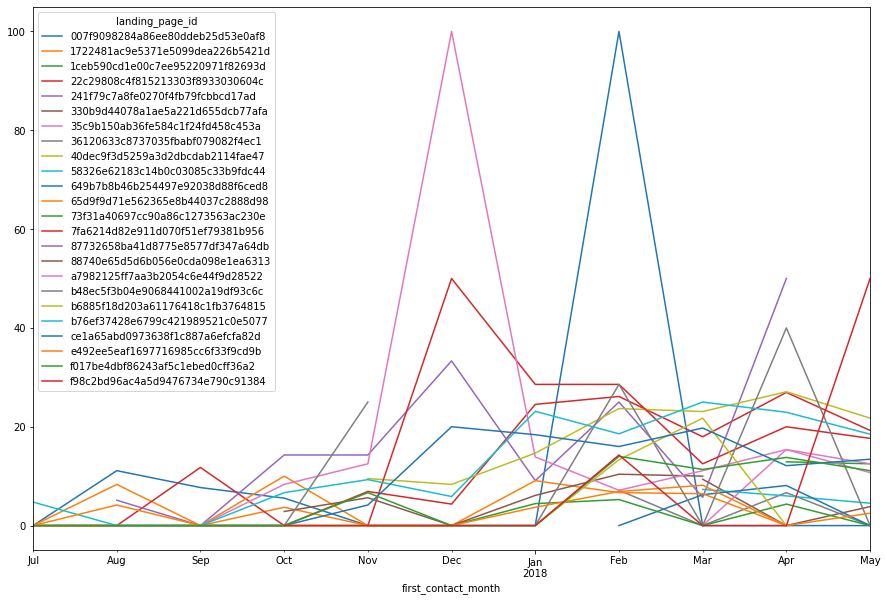

In [ ]:
# seller_전환율 
# pivot table로 전환 
seller_conversion_per_landing_date_pivot = pd.pivot_table(conversion_per_landing_first_50, values='seller_conversion_rate(%)', columns=['landing_page_id'],
                    index=['first_contact_month'])
seller_conversion_per_landing_date_pivot.plot(figsize = (15, 10))

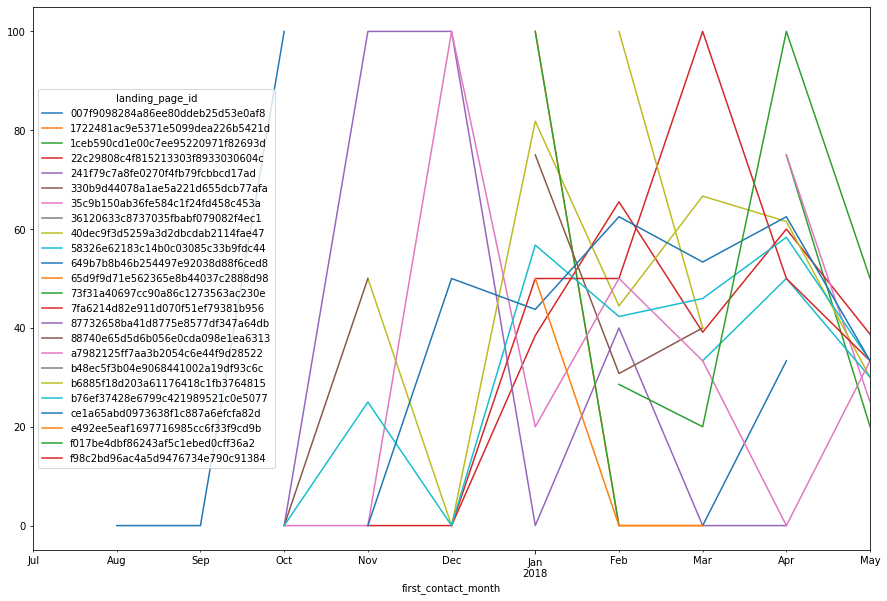

In [ ]:
# order_전환율
order_conversion_per_landing_date_pivot = pd.pivot_table(conversion_per_landing_first_50, values='order_conversion_rate(%)', columns=['landing_page_id'],
                    index=['first_contact_month'])
order_conversion_per_landing_date_pivot.plot(figsize = (15, 10))

### 3) first_contact_date 별 전환율

In [ ]:
# 
b = pd.to_datetime(mf_orders['first_contact_date']).dt.to_period('M')
b

0       2018-02
1       2017-10
2       2018-03
3       2018-01
4       2018-02
         ...   
7995    2018-05
7996    2018-03
7997    2017-08
7998    2017-10
7999    2018-01
Name: first_contact_date, Length: 8000, dtype: period[M]